In [58]:
import pandas as pd 
import numpy as np 
import seaborn as sns

import warnings
warnings.filterwarnings(action='once')

### Chargement des données 

In [59]:
merged = pd.read_csv('../data_CROUS/data_processed/merged_one_hot/merged_Forms_Choix.csv' , sep=",", encoding='latin-1')

### Calcul des similarités entre les plateaux

Le produit scalaire entre le plateau d'un individu et celui de ses convives est beaucoup plus important que celui avec le reste des personnes. Evidemment que des gens qui n'ont pas mangé le meme jour vont avoir des plats différents, et donc des valeurs de produit scalaire nulles.
--> il faut calculer uniquement avec ceux ayant mangé le meme jour / ou alors utiliser une représentation des données qui permet de mettre tout le monde sur le meme plan (ex : au lieu d'avoir boeufbourguinon / escalpe viennoise en 2 colonnes différentes, faire une colonne unique "viande")

#### A - Calcul des similarités de plateaux pour les personnes ayant mangé le meme jour 

In [60]:
# On charge les données pour acceder à qui a mangé quel jour
oct_21 = pd.read_csv('../data_CROUS/data_processed/one_hot/Resultats_choix_21_octobre_onehot.csv' , sep=";")
oct_22 = pd.read_csv('../data_CROUS/data_processed/one_hot/Resultats_choix_22_octobre_onehot.csv' , sep=";")
oct_28 = pd.read_csv('../data_CROUS/data_processed/one_hot/Resultats_choix_28_octobre_onehot.csv' , sep=";")
oct_29 = pd.read_csv('../data_CROUS/data_processed/one_hot/Resultats_choix_29_octobre_onehot.csv' , sep=";")

print(oct_21.columns)

# On crée la liste des num form des gens qui ont mangé le même jour 
nf_oct_21 = list(oct_21['Numéro de formulaire '])
nf_oct_22 = list(oct_22['Numéro de formulaire '])
nf_oct_28 = list(oct_28['Numéro de formulaire '])
nf_oct_29 = list(oct_29['Numéro de formulaire '])

Index(['Unnamed: 0', 'Numéro de formulaire ', 'chouxblancàlajaponaise',
       'saladelentilles', 'champignons', 'carottesrâpées', 'oeufmimosa',
       'saladepates', 'artichauts', 'salami', 'coeursdepalmiers', 'tomates',
       'torsades', 'feuilletésaumonoseille', 'boeufbourguignon', 'kebab',
       'risottocourgettes', 'pizzaraclette', 'faux-filet',
       'pizzamerguezpoivrons', 'hamburger', 'escalopeviennoise',
       'poeléebrocolis', 'frites', 'ratatouille', 'yaourtauxfruits',
       'ufàlaneige', 'faissellenature', 'yaourtnaturesucré',
       'fromageblancfruitsrouges', 'banane', 'mimolette', 'flancchocolat',
       'orange', 'pommegolden', 'kiwi'],
      dtype='object')


In [72]:
distances = pd.DataFrame(columns = ['individu', 'corr_tot', 'corr_convives'])
moy_nf_oct_21 = []
moy_nf_oct_22 = []
moy_nf_oct_28 = []
moy_nf_oct_29 = []

for i, n_form in enumerate(merged['index']):
    #print(n_form)

    # ------- On crée la liste de tous les amis de l'individu que l'on étudie ------------
    friends = []
    for colonne in ['Ami 1','Ami 2','Ami 3','Ami 4','Ami 5', 'Ami 6', 'Ami 7', 'Ami 8', 'Ami 9', 'Ami 10','Ami 11', 'Ami 12', 'Ami 13', 'Ami 14' ]:
        num_friend = merged[colonne][i]
        if type(num_friend) == str:
            friends.append(num_friend)

    # ---- On calcule le produit scalaire entre le plateau de l'individu et celui de chacun de ses amis  ------------
    ps_convives = 0 # on initialise la somme du produit scalaire à 0 

    # plateau 1 est le plateau de l'individu étudié 
    plateau_1 = np.array(merged.loc[merged['index'] == n_form]).flatten()
    plateau_1 = plateau_1[40:-1] # on ne s'interesse qu'aux colonnes qui renseignent les plats 

    for ami in friends:
        if (merged['index'] == ami).sum(): # si l'ami existe (= a bien rendu son formulaire )
            plateau_2 = np.array(merged.loc[merged['index'] == ami]).flatten() # le plateau de l'ami 
            plateau_2 = plateau_2[40:-1]
            
            #print(len(plateau_1), len(plateau_2))
            #try:
            ps_convives += np.dot(plateau_1, plateau_2.T)
            #print(ps_convives, "ps_convives")
            #except:
            #    pass
        else : 
            friends.remove(ami)
    
    # -------- On normalise le cumul des produits scalaire par le nombre d'amis -------
    try:
        ps_convi_norm = ps_convives/len(friends)
    except:
        ps_convi_norm = np.nan # si l'individu  mangé seul (== len(friends) = 0), alors corrélation avec le plateau de ses amis = 0 
    #print(ps_convi_norm, 'ps_coniv_norm')

    # ----------- On calcule le produit scalaire entre tous les plateau DU MEME JOUR et celui de l'indiv étudié   ------------
    ps_tot = 0

    if n_form in nf_oct_21:
        jour = nf_oct_21
    if n_form in nf_oct_22:
        jour = nf_oct_22
    if n_form in nf_oct_28:
        jour = nf_oct_28
    if n_form in nf_oct_29:
        jour = nf_oct_29

    #print(jour)
    for indiv in jour:
        if indiv != n_form:
            try:
                plateau_2 = np.array(merged.loc[merged['index'] == indiv]).flatten()
                plateau_2 = plateau_2[40:-1]
                ps_tot += np.dot(plateau_1, plateau_2.T)

            except:
                pass # cas où le numero de formulaire de la personne n'est plus dans le df processed 
                    # --> il n'y a rien à calculer 

    if jour == nf_oct_21:
        moy_nf_oct_21.append(ps_tot/(len(jour)-1))
    if jour == nf_oct_22:
        moy_nf_oct_22.append(ps_tot/(len(jour)-1))
    if jour == nf_oct_28:
        moy_nf_oct_28.append(ps_tot/(len(jour)-1))
    if jour == nf_oct_29:
        moy_nf_oct_29.append(ps_tot/(len(jour)-1))

    # On rajoute la ligne 
    #print(n_form, ps_tot/len(merged), ps_convi_norm)
    distances = pd.concat([distances,pd.DataFrame.from_records([{'individu' : n_form,'corr_tot' : ps_tot/len(jour), 'corr_convives': ps_convi_norm}])]) # on ajoute la ligne 


In [68]:
print(len(nf_oct_21), len(nf_oct_22), len(nf_oct_28), len(nf_oct_29))
print(np.array(moy_nf_oct_21).mean(), np.array(moy_nf_oct_22).mean(), np.array(moy_nf_oct_28).mean(), np.array(moy_nf_oct_29).mean())

131 69 170 67
1.2362082362082363 1.3188025210084031 1.31278494519352 1.0995670995670996


/var/folders/s4/jtrzm_q55_z39rcm6p6xtgp40000gn/T/ipykernel_1592/2320678156.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sns.heatmap(distances[['corr_tot', 'corr_convives']][0:25], cmap = 'Oranges', square=True, yticklabels=distances['individu'][0:25], xticklabels=['total', 'convives'])


<AxesSubplot: >

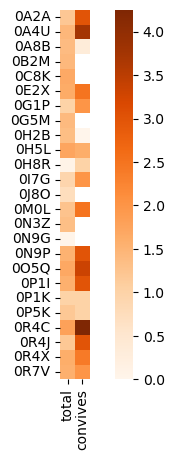

In [69]:
sns.heatmap(distances[['corr_tot', 'corr_convives']][0:25], cmap = 'Oranges', square=True, yticklabels=distances['individu'][0:25], xticklabels=['total', 'convives'])

In [70]:
# On va calculer la moyenne des corremations entre les plateaux des amis et les plateaux des individus totaux. 
# Pour mieux faire apparaitre notre signal, il faut enlever les 'NaN' --> ceux qui ont magé tous euls et à qui on a attribué 
# la valeur 0 

mean_tot = distances['corr_tot'].mean()
mean_convives = distances['corr_convives'].mean(skipna = True)

print(mean_tot, mean_convives)

1.2470100131887627 1.773242304467601


On observe qu'il y a effectiveent une corrélation entre le plateau de l'indiv et de ses amis plus forte que le plateau d'une personne et des autres individus lambda du meme jour. 